# Using a Creator to Calculate True Posteriors for a Galaxy Sample

This notebook demonstrates how to use a RAIL Creator to calculate true posteriors for galaxy samples drawn from the same Creator. Note that this notebook assumes you have already read through `degradation-demo.ipynb`.

Calculating posteriors is more complicated than drawing samples, because it requires more knowledge of the engine that underlies the Creator. In this example, we will use the same engine we used in Degradation demo: `FlowEngine` which wraps a normalizing flow from the [pzflow](https://github.com/jfcrenshaw/pzflow) package.

This notebook will cover three scenarios of increasing complexity:
1. [**Calculating posteriors without errors**](#NoErrors)
2. [**Calculating posteriors while convolving errors**](#ErrConv)
3. [**Calculating posteriors with missing bands**](#MissingBands)

In [1]:
from pzflow.examples import get_example_flow
from rail.creation import Creator, engines
from rail.creation.degradation import LSSTErrorModel, InvRedshiftIncompleteness, LineConfusion, BandCut
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Found classifier FZBoost
Found classifier randomPZ
Found classifier simpleNN
Found classifier trainZ
Found classifier BPZ_lite


# NOTE

This notebook is currently a mess. I decided not to plot the same galaxies for all, because I want to include a 99 band cut to show how to cut those galaxies out if you want. However, at the end, I can make a plot showing true, err conv, err conv w/ band missing as a demo.

Need to walk through this stuff again and make sure it all works. I think I stopped working half way through an edit!

<a id="NoErrors"></a>
## 1. Calculating posteriors without errors

For a basic first example, let's make a Creator with no degradation and draw a sample.

In [2]:
# create the FlowEngine
flowEngine = engines.FlowEngine(get_example_flow())
# create the Creator for the true distribution
creator_truth = Creator(flowEngine)
# draw a few samples
samples_truth = creator_truth.sample(6, seed=1)

Now, let's calculate true posteriors for this sample. Note the important fact here: these are literally the true posteriors for the sample because pzflow gives us direct access to the probability distribution from which the sample was drawn!

When calculating posteriors, the Creator will always require `data`, which is a pandas DataFrame of the galaxies for which we are calculating posteriors. Creator also requires `column` which is the name of the variable for which we are calculating posteriors. (Normally in RAIL we are calculating redshift posteriors, but you can use the Creator to calculate posteriors for the photometry as well if you wish)

`data` and `column` are required for posterior calculation, no matter the engine that underlies the Creator. However, because we are using `FlowEngine`, and because `FlowEngine` calculates posteriors over a grid, we must also provide `grid`.

Let's calculate posteriors for every galaxy in our sample:

In [27]:
grid = np.linspace(0, 2.5, 100)
pdfs = creator_truth.get_posterior(samples_truth, "redshift", grid=grid)

Note that Creator returns the pdfs as a [qp](https://github.com/LSSTDESC/qp) Ensemble:

In [28]:
pdfs

Let's plot these pdfs: 

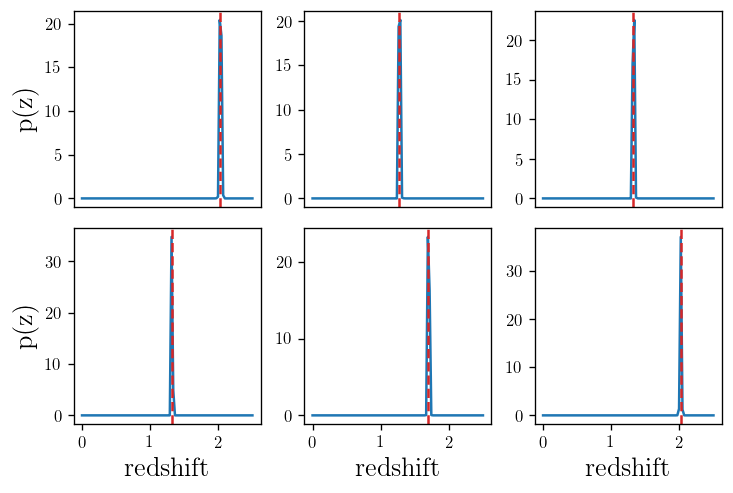

In [29]:
fig, axes = plt.subplots(2, 3, constrained_layout=True, dpi=120)

for i, ax in enumerate(axes.flatten()):

    # plot the pdf
    pdfs[i].plot_native(axes=ax)

    # plot the true redshift
    ax.axvline(samples_truth["redshift"][i], c="C3", ls="--")

    # remove x-ticks on top row
    if i < 3:
        ax.set(xticks=[])
    # set x-label on bottom row
    else:
        ax.set(xlabel="redshift")
    # set y-label on far left column
    if i % 3 == 0:
        ax.set(ylabel="p(z)")

<a id="ErrConv"></a>
## 2. Calculating posteriors while convolving errors
Now, let's get a little more sophisticated.

Let's recreate the Creator we were using at the end of the Degradation demo. 

I will make one change however:
the LSST Error Model sometimes results in non-detections for faint galaxies.
These non-detections are flagged with the value 99.
Calculating posteriors for galaxies with missing magnitudes is more complicated, so for now, I will add one additional BandCut to remove any galaxies with missing magnitudes.
To see how to calculate posteriors for galaxies with missing magnitudes, see [Section 3](#MissingBands).

In [7]:
# set up the error model
errorModel = LSSTErrorModel(bandNames={f"lsst_{b}": b for b in "ugrizy"})

def degrader_cut_nondetects(data: pd.DataFrame, seed: int = None) -> pd.DataFrame:
    # apply the error model
    data = errorModel(data, seed)

    # make a cut on the observed i band
    data = BandCut({"i": 25.3})(data, seed)

    # introduce redshift incompleteness
    data = InvRedshiftIncompleteness(0.8)(data, seed)

    # introduce spectroscopic errors
    # Oxygen lines (in angstroms)
    OII = 3727
    OIII = 5007
    # 2% OII -> OIII confusion
    data = LineConfusion(true_wavelen=OII, wrong_wavelen=OIII, frac_wrong=0.02)(data, seed)
    # 1% OIII -> OII confusion
    data = LineConfusion(true_wavelen=OIII, wrong_wavelen=OII, frac_wrong=0.01)(data, seed)

    # remove all galaxies with missing magnitudes
    data = BandCut({band: 99 for band in "ugrizy"})(data, seed)

    return data

In [8]:
creator_degraded = Creator(flowEngine, degrader=degrader_cut_nondetects)

Now let's draw a degraded sample:

In [9]:
samples_degraded = creator_degraded.sample(6, seed=1)
samples_degraded

,redshift,u,u_err,g,g_err,r,r_err,i,i_err,z,z_err,y,y_err
0,1.272837,25.929161,0.181109,25.286169,0.032071,24.510694,0.016107,23.880899,0.013863,23.332024,0.014915,22.796236,0.020717
1,0.766616,25.588285,0.132537,25.285575,0.032054,24.822778,0.020953,24.041698,0.015778,23.766106,0.021453,23.770953,0.049304
2,0.578591,26.644203,0.349175,26.350709,0.084127,25.633463,0.043019,25.210058,0.043822,25.092259,0.070466,25.185758,0.180068
3,0.480902,24.645506,0.056197,23.628989,0.008685,22.404392,0.005526,21.826375,0.005423,21.557643,0.005778,21.356251,0.007419
4,0.989111,26.416320,0.283212,26.724954,0.118529,25.868717,0.053256,25.249043,0.045397,24.623952,0.046005,24.569785,0.102275
5,0.987142,26.505486,0.307387,26.079838,0.065689,24.864404,0.021719,23.887102,0.013931,23.133976,0.012762,22.828902,0.021308


This sample has photometric errors that we would like to convolve in the redshift posteriors, so that the posteriors are fully consistent with the errors. We can perform this convolution by sampling from the error distributions, calculating posteriors, and averaging.

`FlowEngine` has this functionality already built in - we just have to provide `err_samples` to the `get_posterior` method.

Let's calculate posteriors with a variable number of error samples.

In [15]:

pdfs_errs_convolved = {
    err_samples:
    creator_truth.get_posterior(samples_degraded, "redshift", grid=grid, err_samples=err_samples)
    for err_samples in [1, 10, 100, 1000]
}

AttributeError: 'AxesSubplot' object has no property 'xlabel_fontsize'

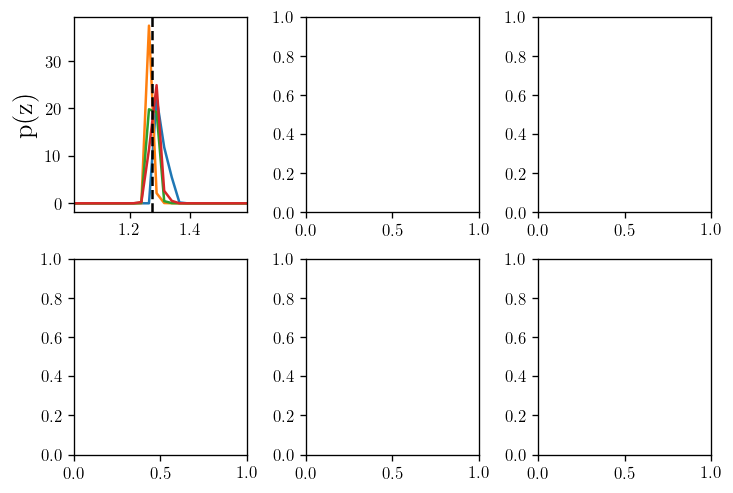

In [70]:
fig, axes = plt.subplots(2, 3, constrained_layout=True, dpi=120)

for i, ax in enumerate(axes.flatten()):

    xlim = [3, 0]

    for pdfs_ in pdfs_errs_convolved.values():
        # plot the pdf
        pdfs_[i].plot_native(axes=ax)
        # get the min and max values
        xmin = grid[np.argmax(pdfs_[i].pdf(grid)[0] > 1e-2)]
        if xmin < xlim[0]:
            xlim[0] = xmin
        xmax = grid[-np.argmax(pdfs_[i].pdf(grid)[0, ::-1] > 1e-2)]
        if xmax > xlim[1]:
            xlim[1] = xmax

    # plot the true redshift
    z_true = samples_degraded["redshift"][i]
    ax.axvline(z_true, c="k", ls="--")

    # remove x-ticks on top row
    if i < 3:
        #ax.set(xticks=[])
        pass
    # set x-label on bottom row
    else:
        ax.set(xlabel="redshift")
    # set y-label on far left column
    if i % 3 == 0:
        ax.set(ylabel="p(z)")

    # set the x-limits so we can see more detail
    xlim[0] -= 0.2
    xlim[1] += 0.2
    ax.set(xlim=xlim)

In [71]:
help(ax.set)

Help on method set in module matplotlib.artist:

set(**kwargs) method of matplotlib.axes._subplots.AxesSubplot instance
    A property batch setter.  Pass *kwargs* to set properties.



In [57]:
pdfs[0].pdf(grid)[0, 76]

0.0004313977369312612

In [60]:
grid[77]

1.9444444444444444